In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gensim
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from zeugma.embeddings import EmbeddingTransformer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import NN

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
#initialize parameters
RANDOM_STATE = 11
TRAIN_SIZE = 0.6
DEV_SIZE = 0.2

#load lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
#load Word2Vec model
#the GoogleNews W2V embeddings and the 42B GLoVe embeddings should be downloaded and placed in a models folder
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin.gz', binary=True)

#load GLoVe model
glove_model_path = './models/glove.42B.300d.txt' 
glove_model = {}
with open(glove_model_path, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_model[word] = coefs

Found 1917495 word vectors.


## Open data

In [4]:
#open sexism dataset
data = pd.read_csv('Sexism_data/ISEPSexistDatalabeling.csv', sep=';')
#shuffle the data
data = data.sample(frac=1, random_state=RANDOM_STATE)
data

,Sentences,Label
353,Well I'd bet on the latter.,0
289,"ah girls, you are dumb if you really believe y...",1
870,The human worker will go the way of the horse.,0
419,"I must admit the ""Women belong in the kitchen""...",1
57,Please Miss be nice and bring us some coffee,1
...,...,...
850,A man is not idle because he is absorbed in th...,0
583,Women sports reporters always look like they h...,1
332,Can you give an example?,0
1115,Shallow men believe in luck. Strong men believ...,0


In [5]:
print(f"The dataset contains {len(data[data['Label'] == 1])} sentences that are labelled to be sexist ({round(100*len(data[data['Label'] == 1])/len(data),2)}%)")
print(f"And {len(data[data['Label'] == 0])} sentences labelled not to be sexist ({round(100*len(data[data['Label'] == 0])/len(data),2)}%)")

The dataset contains 624 sentences that are labelled to be sexist (54.88%)
And 513 sentences labelled not to be sexist (45.12%)


## Preprocess data

In [8]:
#split data into the train, dev and test set
trainset, devset, testset = np.split(data, [int(TRAIN_SIZE*len(data)), int(TRAIN_SIZE*len(data))+int(DEV_SIZE*len(data)) ])

In [9]:
def preprocess_sents(data):
    '''
    Function that preprocesses sentences by tokenizing them and lemmatizing the tokens. 
    The input sentences are split from the annotations and returned separately. 
    To create TF-IDF vectors, the sentences should be strings while they remain tokenized for the other models.
    Therefore the function returns two different lists, one to create TF-IDF vectors and one to create the embeddings
    
    :param data: dataset containing sentences and annotations to be preprocessed
    :type data: pandas dataset
    
    :returns embeddings_corpus: sentences from the data, lemmatized and tokenized
    :type embeddings_corpus: list of lists
    :returns embeddings_corpus: sentences from the data, lemmatized
    :type embeddings_corpus: list of strings
    :returns targets: annotations from the data
    :type targets: list of integers 
    '''
    embeddings_corpus = []
    tf_idf_corpus = []
    targets = []
    #iterate the data
    for row in data.iterrows():
        #skip inputs empty inputs or inputs that aren't strings
        try:
            #lemmatize and tokenize
            sent = [wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(row[1]['Sentences'].lower())]
            embeddings_corpus.append(sent)
            #for the TF-IDF embeddings, save data as sentences
            tf_idf_corpus.append(" ".join(sent))
            #save target annotations
            target = row[1]['Label']
            targets.append(target)
        except: 
            continue
    return embeddings_corpus, tf_idf_corpus, targets

In [13]:
#split data in sentences and labels
train_embeddings, train_tf, y_train = preprocess_sents(trainset)
dev_embeddings, dev_tf, y_dev = preprocess_sents(devset)
test_embeddings, test_tf, y_test = preprocess_sents(testset)

## Extract word vectors

In [14]:
def extract_word_embedding(token, word_embedding_model):
    '''
    Function that returns the word embedding for a given token out of a distributional semantic model.
    If the token is not present in the embeddings model, a 300-dimension vector of 0s is returned.
    
    :param token: the token
    :param word_embedding_model: the distributional semantic model
    :type token: string
    :type word_embedding_model: gensim.models.keyedvectors.Word2VecKeyedVectors
    
    :returns a vector representation of the token
    '''
    if token in word_embedding_model:
        vector = word_embedding_model[token]
    else:
        vector = np.zeros(300)
    return vector

In [15]:
def extract_embeddings(data, language_model, combine):
    '''
    Function that extracts word embeddings from a distributional semantic model for each token in the input and 
    combines them using a combine function.
    Combine function 'sum' sums over the individual word vectors; 'mean' takes the mean of individual word vectors
    
    :param data: data containing tokenized input sentences
    :param language_model: a pretrained word embedding model
    :param combine: a string indicating how the word vectors should be combined into sentence vectors
    :type data: list of lists
    :type language_model: gensim.models.keyedvectors.Word2VecKeyedVectors or dict (for GLoVe)
    :type combine: string
    
    :return embeddings: list of vector representation of tokens
    '''
    embeddings = []
    for sent in data:
        sent_embedding = []
        for token in sent:
            embedding = extract_word_embedding(token, language_model)
            sent_embedding.append(embedding)
        if combine == 'mean':
            sent_embedding = np.mean(sent_embedding, axis=0)
        if combine == 'sum':
            sent_embedding = np.sum(sent_embedding, axis=0)
        if sent_embedding.shape != (300,):
            continue
        embeddings.append(sent_embedding)
    embeddings = np.array(embeddings)
    return embeddings

In [16]:
def extract_embeddings_tf(data, fit=False, vectorizer = None, svdT=None):
    '''
    Function that create TF-IDF vectors for each token in the input and 
    combines them using a combine function.
    Combine function 'sum' sums over the individual word vectors; 'mean' takes the mean of individual word vectors
    
    :param data: data containing tokenized input sentences
    :param language_model: a pretrained word embedding model
    :param combine: a string indicating how the word vectors should be combined into sentence vectors
    :type data: list of lists
    :type language_model: gensim.models.keyedvectors.Word2VecKeyedVectors or dict (for GLoVe)
    :type combine: string
    
    :return embeddings: list of vector representation of tokens
    '''
    if fit:
        vectorizer = TfidfVectorizer()
        sparse_embeddings = vectorizer.fit_transform(data)
        svdT = TruncatedSVD(n_components=300)
        embeddings = svdT.fit_transform(sparse_embeddings)
    else:
        sparse_embeddings = vectorizer.transform(data)
        embeddings = svdT.transform(sparse_embeddings)
    return embeddings, vectorizer, svdT

In [17]:
#extract train-dev-test data for TF-IDF vectors
X_train_tf, vectorizer, svdT = extract_embeddings_tf(train_tf, fit=True)
X_dev_tf, _, _ = extract_embeddings_tf(dev_tf, fit=False, vectorizer=vectorizer, svdT=svdT)
X_test_tf, _, _ = extract_embeddings_tf(test_tf, fit=False, vectorizer=vectorizer, svdT=svdT)

In [18]:
#extract train-dev-test data using W2V embeddings
X_train_w2v_mean = extract_embeddings(train_embeddings, w2v_model, 'mean')
X_dev_w2v_mean = extract_embeddings(dev_embeddings, w2v_model, 'mean')
X_test_w2v_mean = extract_embeddings(test_embeddings, w2v_model, 'mean')

X_train_w2v_sum = extract_embeddings(train_embeddings, w2v_model, 'sum')
X_dev_w2v_sum = extract_embeddings(dev_embeddings, w2v_model, 'sum')
X_test_w2v_sum = extract_embeddings(test_embeddings, w2v_model, 'sum')

In [19]:
#extract train-dev-test data using GloVe embeddings
X_train_glove_mean = extract_embeddings(train_embeddings, glove_model, 'mean')
X_dev_glove_mean = extract_embeddings(dev_embeddings, glove_model, 'mean')
X_test_glove_mean = extract_embeddings(test_embeddings, glove_model, 'mean')

X_train_glove_sum = extract_embeddings(train_embeddings, glove_model, 'sum')
X_dev_glove_sum = extract_embeddings(dev_embeddings, glove_model, 'sum')
X_test_glove_sum = extract_embeddings(test_embeddings, glove_model, 'sum')

### Baseline models

In [44]:
#create and test logistic regression baseline model
model = LogisticRegression(max_iter=10000)
model.fit(X_train_tf, y_train)
predictions = model.predict(X_test_tf)
#print performance scores
NN.get_performance_scores(y_test, predictions)

{'accuracy': 0.7631578947368421,
 'precision': 0.7,
 'recall': 0.921,
 'F1': 0.795}

In [45]:
#create and test SVM baseline model
model = svm.LinearSVC()
model.fit(X_train_tf, y_train)
predictions = model.predict(X_test_tf)
#print performance scores
NN.get_performance_scores(y_test, predictions)

{'accuracy': 0.7675438596491229,
 'precision': 0.729,
 'recall': 0.851,
 'F1': 0.785}

## Experiments with embeddings

In [23]:
# set model hyperparameters : number of input, hidden and output nodes
input_nodes = 300
hidden_nodes = 128
output_nodes = 1

#set learning rate, number of epochs and number of random initializations
lr = 0.0005
epochs = 20
n_initializations = 5 


In [24]:
def train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train, y_train, X_dev, y_dev, verbose=False):
    '''
    Function that takes in hyperparameters settings and trains n_initializations number of models with this settings.
    It keeps track of the performance for each model and returns the average scores.
    
    :param n_initializations: the number of random initializations, i.e. the number of models to train; int
    :param input_nodes: the number of input nodes; int
    :param hidden_nodes: the number of hidden nodes; int
    :param output_nodes: the number of output nodes; int
    :param lr: the learning rate; float 
    :param epochs: the number of epochs to train for; int
    :param input_nodes: the number of input nodes 
    :param X_train: input train data; list of vectors
    :param y_train: gold data for the train data; list of ints
    :param X_dev: input dev data; list of vectors
    :param y_dev: gold data for the dev data; list of ints
    :param verbose: settings whether training updates should be printed after each epoch; bool
    
    :return performance_scores: dict including mean performance scores
    '''
    performance_scores = {'accuracy': [], 'precision': [], 'recall': [], 'F1':[]}
    #loop over the initializations
    for n in range(n_initializations):
        #create the model
        model = NN.neuralNetwork(input_nodes, hidden_nodes, output_nodes, lr)
        #train
        NN.train_network(model, epochs, X_train, y_train, X_dev, y_dev, verbose = verbose)
        #test on the dev set
        predictions, scores = NN.test_network(model, X_dev, y_dev)
        #save performance of this initialization
        for measure, score in scores.items():
            performance_scores[measure].append(score)
    #take the mean of the performance scores
    for measure, scores in performance_scores.items():
        print(measure, round(np.mean(scores)*100,1))
    return performance_scores

#### TF-IDF

In [30]:
tf_idf = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_tf, y_train, X_dev_tf, y_dev, verbose=False)

accuracy 58.3
precision 55.0
recall 98.4
F1 70.5


#### W2V mean

In [26]:
w2v_mean = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_w2v_mean, y_train, X_dev_w2v_mean, y_dev, verbose=False)

accuracy 69.0
precision 64.3
recall 89.2
F1 74.5


#### W2V sum

In [27]:
w2v_sum = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_w2v_sum, y_train, X_dev_w2v_sum, y_dev, verbose=False)

accuracy 80.8
precision 74.5
recall 94.4
F1 83.3


#### GLoVe mean

In [28]:
glove_mean = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_glove_mean, y_train, X_dev_glove_mean, y_dev, verbose=False) 

accuracy 83.2
precision 79.3
recall 90.4
F1 84.5


#### GLoVe sum

In [29]:
glove_sum = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_glove_sum, y_train, X_dev_glove_sum, y_dev, verbose=False) 

accuracy 82.1
precision 75.5
recall 95.9
F1 84.5


## experiments with model architecture

In [31]:
#compare models with the following number of hidden nodes
hidden_nodes_ranges = [32, 64, 128, 256, 512, 768, 1012]

In [32]:
performances_hidden_nodes = []
for hidden_nodes in hidden_nodes_ranges:
    print(f"hidden nodes = {hidden_nodes}")
    h_nodes_performace = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_glove_mean, y_train, X_dev_glove_mean, y_dev, verbose=False) 
    print("---")
    performances_hidden_nodes.append(np.mean(h_nodes_performace['accuracy'])*100)

hidden nodes = 32
accuracy 69.9
precision 64.6
recall 92.5
F1 75.9
---
hidden nodes = 64
accuracy 80.4
precision 75.6
recall 90.9
F1 82.5
---
hidden nodes = 128
accuracy 81.9
precision 77.9
recall 89.6
F1 83.3
---
hidden nodes = 256
accuracy 82.6
precision 78.8
recall 89.9
F1 84.0
---
hidden nodes = 512
accuracy 83.5
precision 78.8
recall 92.3
F1 85.0
---
hidden nodes = 768
accuracy 84.4
precision 79.5
recall 93.4
F1 85.8
---
hidden nodes = 1012
accuracy 83.7
precision 78.8
recall 92.9
F1 85.2
---


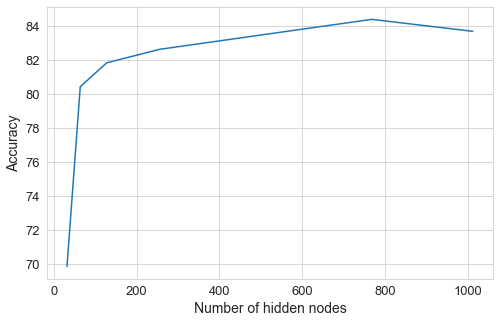

In [33]:
#create plot for hidden nodes results
plt.figure(figsize=(8,5))
plt.plot(hidden_nodes_ranges, performances_hidden_nodes) 
plt.xlabel("Number of hidden nodes", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('hidden_nodes_performance.png')
plt.show()  

In [34]:
#compare models with the following learning rates
hidden_nodes = 768
lr_ranges = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
performances_lr = []

for lr in lr_ranges:
    print(f"learning rate = {lr}")
    lr_performace = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_glove_mean, y_train, X_dev_glove_mean, y_dev, verbose=False) 
    print("---")
    performances_lr.append(np.mean(lr_performace['accuracy'])*100)

learning rate = 1e-05
accuracy 61.0
precision 58.8
recall 78.8
F1 67.2
---
learning rate = 5e-05
accuracy 76.7
precision 73.3
recall 84.9
F1 78.6
---
learning rate = 0.0001
accuracy 82.0
precision 78.4
recall 89.1
F1 83.4
---
learning rate = 0.0005
accuracy 83.1
precision 79.1
recall 90.5
F1 84.4
---
learning rate = 0.001
accuracy 85.5
precision 80.3
recall 94.4
F1 86.8
---
learning rate = 0.005
accuracy 81.5
precision 84.9
recall 77.2
F1 80.9
---
learning rate = 0.01
accuracy 80.5
precision 85.1
recall 74.6
F1 79.5
---


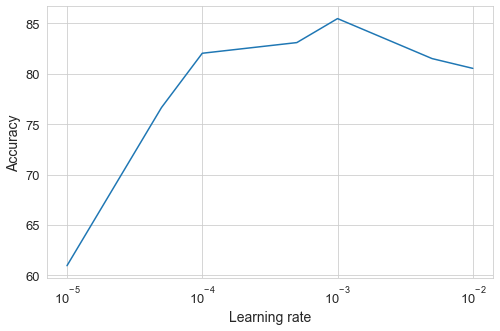

In [35]:
#create and save plot for learning rate results
plt.figure(figsize=(8,5))
plt.plot(lr_ranges, performances_lr) 

plt.xlabel("Learning rate", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')

plt.savefig('lr_performance.png')
plt.show()  

In [36]:
#compare models with the following number of epochs
lr = 0.001
epochs_ranges = [1,5,10,15,20,30,40]

performances_epochs_001 = []
for epochs in epochs_ranges:
    print(f"epochs = {epochs}")
    epochs_performace = train_n_initializations(n_initializations, input_nodes, hidden_nodes, output_nodes, \
                            lr, epochs, X_train_glove_mean, y_train, X_dev_glove_mean, y_dev, verbose=False) 
    print("---")
    performances_epochs_001.append(np.mean(epochs_performace['accuracy'])*100)

epochs = 1
accuracy 76.7
precision 82.0
recall 69.6
F1 75.1
---
epochs = 5
accuracy 82.6
precision 81.0
recall 85.9
F1 83.3
---
epochs = 10
accuracy 84.3
precision 80.4
recall 91.3
F1 85.5
---
epochs = 15
accuracy 83.7
precision 80.0
recall 90.4
F1 84.9
---
epochs = 20
accuracy 84.9
precision 79.6
recall 94.6
F1 86.4
---
epochs = 30
accuracy 85.3
precision 79.9
recall 94.8
F1 86.7
---
epochs = 40
accuracy 85.6
precision 80.5
recall 94.6
F1 87.0
---


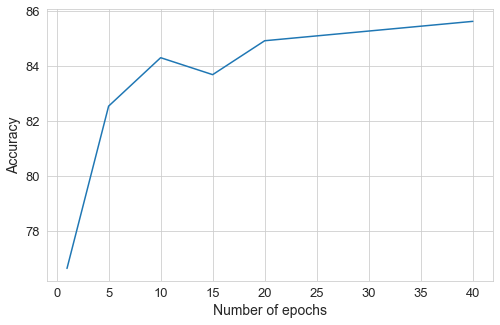

In [38]:
plt.figure(figsize=(8,5))
plt.plot(epochs_ranges, performances_epochs_001) 
plt.xlabel("Number of epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig('epochs_performance.png')
plt.show()  

Train the final model, using all the best hyperparameters:

In [48]:
epochs = 40
model = NN.neuralNetwork(input_nodes,hidden_nodes,output_nodes,lr)
NN.train_network(model, epochs, X_train_glove_mean, y_train, X_dev_glove_mean, y_dev, verbose = True)

Epoch 0/40:
time: 0.001997232437133789 s; train performance: {'accuracy': 0.7771260997067448, 'precision': 0.881, 'recall': 0.711, 'F1': 0.787}
dev performance: {'accuracy': 0.7929515418502202, 'precision': 0.815, 'recall': 0.765, 'F1': 0.789}
Epoch 1/40:
time: 0.003000974655151367 s; train performance: {'accuracy': 0.8240469208211144, 'precision': 0.894, 'recall': 0.79, 'F1': 0.839}
dev performance: {'accuracy': 0.8193832599118943, 'precision': 0.803, 'recall': 0.852, 'F1': 0.827}
Epoch 2/40:
time: 0.003002643585205078 s; train performance: {'accuracy': 0.843108504398827, 'precision': 0.898, 'recall': 0.823, 'F1': 0.859}
dev performance: {'accuracy': 0.8325991189427313, 'precision': 0.813, 'recall': 0.87, 'F1': 0.841}
Epoch 3/40:
time: 0.002000570297241211 s; train performance: {'accuracy': 0.8592375366568915, 'precision': 0.901, 'recall': 0.851, 'F1': 0.875}
dev performance: {'accuracy': 0.8325991189427313, 'precision': 0.808, 'recall': 0.878, 'F1': 0.842}
Epoch 4/40:
time: 0.0030038

Epoch 34/40:
time: 0.0030028820037841797 s; train performance: {'accuracy': 0.9149560117302052, 'precision': 0.912, 'recall': 0.944, 'F1': 0.928}
dev performance: {'accuracy': 0.8678414096916299, 'precision': 0.806, 'recall': 0.974, 'F1': 0.882}
Epoch 35/40:
time: 0.0020058155059814453 s; train performance: {'accuracy': 0.9164222873900293, 'precision': 0.912, 'recall': 0.947, 'F1': 0.929}
dev performance: {'accuracy': 0.8678414096916299, 'precision': 0.806, 'recall': 0.974, 'F1': 0.882}
Epoch 36/40:
time: 0.004025459289550781 s; train performance: {'accuracy': 0.9164222873900293, 'precision': 0.912, 'recall': 0.947, 'F1': 0.929}
dev performance: {'accuracy': 0.8678414096916299, 'precision': 0.806, 'recall': 0.974, 'F1': 0.882}
Epoch 37/40:
time: 0.0020127296447753906 s; train performance: {'accuracy': 0.9164222873900293, 'precision': 0.912, 'recall': 0.947, 'F1': 0.929}
dev performance: {'accuracy': 0.8678414096916299, 'precision': 0.806, 'recall': 0.974, 'F1': 0.882}
Epoch 38/40:
time

In [49]:
print("test performance for the best NN model")
y_pred, final_performance = NN.test_network(model, X_test_glove_mean, y_test)
print(final_performance)

test performance for the best NN model
{'accuracy': 0.8245614035087719, 'precision': 0.768, 'recall': 0.93, 'F1': 0.841}


## Error analysis

In [50]:
#get indices of all sexist (annotation = 1) sentences
positives_indices = [index for index, annotation in enumerate(y_test) if annotation == 1]
#get indices of all correctly indentified sexist sentences (true positives)
true_positives_indices = [index for index in positives_indices if y_pred[index]==1]
#get indices of all incorrectly classified sexist sentences (false negatives)
false_positives_indices = [index for index in positives_indices if y_pred[index]==0]
print(f"out of {len(positives_indices)} sexist sentences in the testset, {len(true_positives_indices)} are correctly " \
        f"identified, {len(false_positives_indices)} are missed.")

#get indices of all sexist (annotation = 0) sentences
negatives_indices = [index for index, annotation in enumerate(y_test) if annotation == 0]
#get indices of all correctly indentified neatral sentences (true negatives)
true_negatives_indices = [index for index in negatives_indices if y_pred[index]==0]
#get indices of all incorrectly classified neatral sentences (false positives)
false_negatives_indices = [index for index in negatives_indices if y_pred[index]==1]
print(f"out of {len(negatives_indices)} neutral sentences in the testset, {len(true_negatives_indices)} are correctly " \
        f"identified, {len(false_negatives_indices)} are considered as sexist.")


out of 114 sexist sentences in the testset, 106 are correctly identified, 8 are missed.
out of 114 neutral sentences in the testset, 82 are correctly identified, 32 are considered as sexist.


In [51]:
print("false positive sentences:")
for index in false_positives_indices:
    print(" ".join(test_w2v[index]))

false positive sentences:
test are like woman . hard to understand , easy to get over , and nonrefundable .
i just think men are better comedian .
what will we do without feminist ? ! everything .
for a woman , that is good
you can thank the quota
how do you sleep at night , cathy ? you . cunt .
for me , she is not strong enough
i think in general , men make way better music


In [52]:
print("false negative sentences:")
for index in false_negatives_indices:
    print(" ".join(test_w2v[index]))

false negative sentences:
i hate being placed on committee . they are always having meeting at which half are absent and the rest late .
i never sleep well when i 'm on call .
you are a intelligent a this guy
do you and your little girl watch sport together ?
the woman 's party is made up of woman of all race , creed and nationality who are united on the one program of working to raise the status of woman .
i 'm not someone who 's led my life trying to get publicity i 'd rather do my work and go home .
all job are odd , or they would be game or nap or picnic .
when a man is ambitious it 's seen a a good thing , and when a woman is described a ambitious it 's seen a a complete negative
people buy into the leader before they buy into the vision
five foot and nine inch is tall for a girl right ?
a woman is just a good a a man
i 'm just a good a a man . i do n't need a special day to celebrate that .
men can have parental leave a woman
most business meeting involve one party elaborately su